<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Homework2" data-toc-modified-id="Homework2-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Homework2</a></span></li></ul></li><li><span><a href="#Школа-GataScientist,-декабрь-2022,-Андреева-Ольга" data-toc-modified-id="Школа-GataScientist,-декабрь-2022,-Андреева-Ольга-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Школа GataScientist, декабрь 2022, Андреева Ольга</a></span></li><li><span><a href="#Собрать-информацию-о-всех-строящихся-объектах-на-сайте-&quot;наш.дом.рф&quot;." data-toc-modified-id="Собрать-информацию-о-всех-строящихся-объектах-на-сайте-&quot;наш.дом.рф&quot;.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф".</a></span></li><li><span><a href="#Проверить-состояние-датафрейма-и-привести-его-в-формат,-позволяющий-дальнейшее-исследование-данных:" data-toc-modified-id="Проверить-состояние-датафрейма-и-привести-его-в-формат,-позволяющий-дальнейшее-исследование-данных:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:</a></span></li><li><span><a href="#Провести-мини-исследование-рынка-строящейся-недвижимости-в-одном-или-нескольких-регионах-с-помощью-pandas,-matplotlib,-seaborn,-plotly-и-других-инструментов." data-toc-modified-id="Провести-мини-исследование-рынка-строящейся-недвижимости-в-одном-или-нескольких-регионах-с-помощью-pandas,-matplotlib,-seaborn,-plotly-и-других-инструментов.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.</a></span></li></ul></div>

## Homework2
# Школа GataScientist, декабрь 2022, Андреева Ольга

# Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф".
Cохранить ее в pandas dataframe

In [1265]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [ ]:
#функция для получения общего количества id-шников
def getTotalCount():
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=1&limit=1&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
    return  res.json().get('data').get('total')

#функция для чтения пачки id-шников
def readIDs(p_offset, p_limit):
    c_http_success = 200
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={p_offset}&limit={p_limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    res = requests.get(url)
    if res.status_code == c_http_success:
        try:
            objects_data = res.json()
            objects_list = objects_data.get('data').get('list')
            return {'state': c_http_success, 'data':[x.get('objId') for x in objects_list]}
        except IndexError:
            return({'state': c_http_success,'data': []});
    else:
        return({'state': res.status_code, 'data': []})
    
#функция для чтения объекта по id-шнику
def readObjectData (p_ObjID):
    # Для скачивания данных по определенному объекту, нужно добавить его id в конец строки запроса
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{p_ObjID}'
    res = requests.get(url)
    return res.json().get('data')    

In [ ]:
v_offset = 1
v_limit = 100
c_max_limit = getTotalCount() #getTotalCount() - если надо скачать ВСЕ записи
lst_Objects=[]
df_Objects=pd.DataFrame([])
c_http_success = 200

print ("must get: ", c_max_limit)

from datetime import datetime
import time
start_time = datetime.now()

while True:
    #обработка ограничения по количеству записей
    if v_offset + v_limit > c_max_limit:
        v_limit = c_max_limit - v_offset + 1
    
    v_IDs_bath = readIDs(v_offset, v_limit) #cчитали порцию id-шников
    
    if v_IDs_bath.get('state') != c_http_success:
        print (v_IDs_bath.get('state'), "на ", v_offset, "!")
    else:
        v_IDs=v_IDs_bath.get('data')
        print(v_offset, " - code ", v_IDs_bath.get('state'))
        #читаем каждый объект по ID
        lst_Objects=[]
        for i in (v_IDs):
            v_Object=readObjectData(i) 
            lst_Objects.append(v_Object)

        #добавляем пачку объектов в датафрейм
        df_Objects=df_Objects.append(pd.DataFrame(lst_Objects),ignore_index=True)     
 
    v_offset += v_limit
    print ("have got: ", v_offset-1)
    if len(v_IDs)<v_limit or v_offset>c_max_limit: break

print('Time: ', datetime.now() - start_time)
   
    

Cохранить pandas dataframe в excel

In [ ]:
df_Objects.head(5)

In [ ]:
df_Objects.to_excel("./df_Objects.xlsx")


In [1436]:
#прочитали - забэкапили
df_Objects=pd.read_excel("./df_Objects.xlsx")
df_Objects_bkp=df_Objects.copy()


In [1906]:
df_Objects=df_Objects_bkp.copy()

# Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
    -- Привести колонки датафрейма к одному типу данных
    -- Проверить индекс, чтобы он соответствовал порядку строк 
    -- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки

In [1907]:
#колонки, которые будем использовать в анализе
map_columns=dict({'address':'адрес',
'developer':'застройщик',
#'floorMax':'Этаж макс',
#'floorMin':'этаж мин',
#'generalContractorNm':'Генподрядчик',
'greenAreaIndexValue':'Индекс зеленой зоны',
'id':'id',
'infrastructureIndexValue':'Индекс доступности инфраструктуры',
#'loadDttm':'дата загрузки',
'nameObj':'Название объекта',
'nonlivFirstFloor':'1 этаж нежилой',
'objCompensFundFlg':'гарантии фонда',
#'objElemLivingCnt':'жилых помещениий', #дублирует 'objFlatCnt'
'objElemParkingCnt':'паркомест',
'objElevatorCargoCnt':'грузовых лифтов',
'objElevatorCargoPassengerCnt':'грузопассажирских лифтов',
'objElevatorPassengerCnt':'пассажирских лифтов',
'objElevatorWheelchairCnt':'инвалидных подъемников',
'objEnergyEffShortDesc':'энергоэффективность',
'objFlatCnt':'квартр',
#'objFlatSq':'площадь квартир', #дублирует 'objSquareLiving'
'objFloorCnt':'этажность',
'objGreenHouseFlg':'зеленый дом',
'objGuarantyEscrowFlg':'Продажа квартир через счета эскроу',
'objInfrstrBicycleLaneFlg':'велодорожки',
'objInfrstrCurbLoweringFlg':'Наличие понижающих площадок',
'objInfrstrNotObjPrkngCnt':'парковки внутри территории',
'objInfrstrObjPrkngCnt':'парковки вне территории',
'objInfrstrPlaygrndCnt':'игровые площадки',
'objInfrstrRampFlg':'пандус',
'objInfrstrSportGroundCnt':'спортплощадки',
'objInfrstrTrashAreaCnt':'мусорных площадок',
'objLivCeilingHeight':'высота потолков',
'objLkClassDesc':'тип застройки',
'objLkFinishTypeDesc':'отделка',
'objLkFreePlanDesc':'свободная планировка',
'objLkLatitude':'широта',
'objLkLongitude':'долгота',
#'objLkSaleDepEmail':'е-мейл',
'objNonlivElemCnt':'нежилых помещений',
'objPriceAvg':'средняя цена м2',
'objProblemFlg':'проблемный',
'objReady100PercDt':'дата сдачи',
'objSquareLiving':'площадь жилых',
'objStatus':'статус',
'objectTransportInfo':'транспорт',
'residentialBuildings':'жилой объект',
'region':'регион',
'soldOutPerc':'продано %',
'wallMaterialShortDesc':'материал стен',
##колонки, которые выделим по ходу
'devId':'ID застройщика',
'devRegion':'регион застройщика',
'objectDistToMetro':'расстояние до метро'
})


In [1908]:
#оставлю только интересные столбцы 
df_Objects=df_Objects.loc[:,list(map_columns.keys())]

In [1909]:
#преобразование высоты потолков в число
import re
def CeilingHeight_to_number(p_height):
    try:
        v_height=p_height.replace(',','.')
        res=re.findall('\d+(?:\.\d+)?', v_height)
        res=[float(n) for n in res]
        return max(res)   
    except ValueError:
        return None
    except AttributeError:
        return None
CeilingHeight_to_number(None)

#вычисление ближайшего растояния до метро
def DistToMetro (p_sttn_list):
    try:
        v_sttns=[s.get('metroStationDistLength') for s in p_sttn_list]
        return min(v_sttns)
    except ValueError:
        return None
    except AttributeError:
        return None


In [1910]:
#преобразование типов
# от застройщика оставляю только ID и регион
df_Objects['developer']=df_Objects['developer'].apply(eval)
df_Objects['devId']=df_Objects['developer'].apply(lambda x: x.get('devId'))
df_Objects['devRegion']=df_Objects['developer'].apply(lambda x: x.get('devOrgRegRegionCd'))
df_Objects=df_Objects.drop('developer', axis=1)

#от транспортной доступности оставляю расстояние до ближайшего метро
df_Objects['objectDistToMetro']=df_Objects['objectTransportInfo'].apply(eval).apply(lambda x: DistToMetro(x))
df_Objects=df_Objects.drop('objectTransportInfo', axis=1)


#дату сдачи - в дату
df_Objects['objReady100PercDt']=pd.to_datetime(df_Objects['objReady100PercDt'], format="%Y-%m-%d")

#высоту потолков - в число
df_Objects['objLivCeilingHeight']=df_Objects['objLivCeilingHeight'].apply(lambda x: CeilingHeight_to_number(x))

#свободную планировку - в число
df_Objects['objLkFreePlanDesc']=df_Objects['objLkFreePlanDesc'].map({'Есть':1, 'Нет':2})

In [1911]:
#преобразование классов энергоэффективности, классса жилья, типа отделки
print((df_Objects['objEnergyEffShortDesc'].unique()))
print(df_Objects['objLkClassDesc'].unique())
print(df_Objects['objLkFinishTypeDesc'].unique())

['B' 'D' 'C' 'A++' 'A' 'A+' 'Не нормируется' 'F' 'E' 'G']
['Элитный' 'Комфорт' 'Другое' 'Бизнес' 'Типовой']
['По желанию заказчика' 'Без отделки' 'Под чистовую' 'Под ключ' 'Другое']


In [1912]:
map_objEnergy = dict({'A++':9, 'A+':8, 'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1, 'Не нормируется':0})
df_Objects['objEnergyEffShortDesc']=df_Objects['objEnergyEffShortDesc'].map(map_objEnergy)

map_LkClass = dict({'Другое':0,'Типовой':1, 'Комфорт':2, 'Бизнес':3, 'Элитный':4})
df_Objects['objLkClassDesc']=df_Objects['objLkClassDesc'].map(map_LkClass)

In [1913]:
p=[x for x in range(0, 5)]
print(p)

[0, 1, 2, 3, 4]


In [1914]:
v_clmns=['objLkFinishTypeDesc','wallMaterialShortDesc']
for v_clmn in v_clmns:
    v_values=np.sort(df_Objects[v_clmn].unique())
    print(v_values,  [x for x in range(0, len(v_values))])
    map_clmn=dict(zip(v_values, range(0, len(v_values))))
    df_Objects[v_clmn]=df_Objects[v_clmn].map(map_clmn)



['Без отделки' 'Другое' 'По желанию заказчика' 'Под ключ' 'Под чистовую'] [0, 1, 2, 3, 4]
['Блоки' 'Другое' 'Кирпич' 'Монолит' 'Монолит-кирпич' 'Панель'] [0, 1, 2, 3, 4, 5]


In [1915]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    s=df_Objects.dtypes
    print(s.sort_values())

objFlatCnt                               int64
objNonlivElemCnt                         int64
objInfrstrRampFlg                        int64
objProblemFlg                            int64
objReady100PercDt               datetime64[ns]
objInfrstrCurbLoweringFlg                int64
objInfrstrBicycleLaneFlg                 int64
objGuarantyEscrowFlg                     int64
objGreenHouseFlg                         int64
objFloorCnt                              int64
objLkClassDesc                           int64
objEnergyEffShortDesc                    int64
objLkFinishTypeDesc                      int64
objStatus                                int64
objElevatorCargoPassengerCnt             int64
residentialBuildings                     int64
objElemParkingCnt                        int64
objCompensFundFlg                        int64
region                                   int64
wallMaterialShortDesc                    int64
id                                       int64
devId        

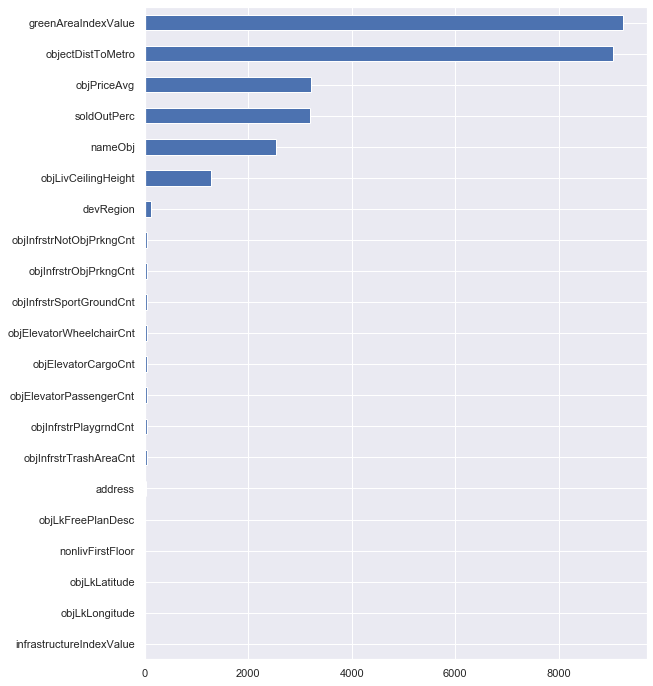

In [1918]:
# Посмотрим, что у нас по пропущенным данным
s_Missing=pd.Series([])
for clmn in df_Objects.columns:
    is_empty = df_Objects[clmn].isnull()
    empty_cnt = np.sum(is_empty)
    s_Missing[clmn] = empty_cnt
# визуализируем
if s_Missing[s_Missing>0].empty==False:
    from pylab import rcParams
    rcParams['figure.figsize'] = 9,12
    s_Missing[s_Missing>0].sort_values(ascending=True).plot(kind='barh')
    plt.grid(True)
    plt.show()
else:
    print ("Ура, пустых значений нет!")


In [1919]:
#заполним нулями пропущенные даныые в колонках "количество..."
# и в колонках 'свободная планировка', '1 этаж нежилой', 'Индекс доступности инфраструктуры', 'продано %', 
s_fill_zero=list(s_Missing[s_Missing.index.str.endswith('Cnt')].index)
s_fill_zero.extend(['objLkFreePlanDesc', 'nonlivFirstFloor', 'infrastructureIndexValue', 'soldOutPerc'])
df_Objects[s_fill_zero]=df_Objects[s_fill_zero].fillna(0)

# 'расстояние до метро' дозаполним нереально большим значением
c_veryBigNum=1000
df_Objects['objectDistToMetro']=df_Objects['objectDistToMetro'].fillna(c_veryBigNum)

In [1929]:
#удалим колонки, ктотрые не заполнеы более чем на 50%
#for clmn in s_Missing[s_Missing>len(df_Objects.index)/2].index:
df_Objects=df_Objects.drop(s_Missing[s_Missing>len(df_Objects.index)/2].index, axis=1)
s_Missing=s_Missing.drop(s_Missing[s_Missing>len(df_Objects.index)/2].index)


In [1930]:
#Заполним пропущенную 'высоту потолков' средним значением
v_mean_Height=df_Objects['objLivCeilingHeight'].mean()
df_Objects['objLivCeilingHeight']=df_Objects['objLivCeilingHeight'].fillna(v_mean_Height)

In [1931]:
#Заполним пропущенные 'средняя цена м2','широта','долгота' средними по региону
v_clmns=['objPriceAvg', 'objLkLatitude', 'objLkLongitude']
s_means=df_Objects.groupby(by='region')[v_clmns].transform('mean')
df_Objects[v_clmns]=df_Objects[v_clmns].fillna(s_means)

#если еще oостались незаполненные, то заполняем нулями 
df_Objects[v_clmns]=df_Objects[v_clmns].fillna(0)

In [1932]:
#поищем пропущенный регион застройщика по id застройщика
s_means=df_Objects.groupby(by='devId')['devRegion'].transform('max')
df_Objects['devRegion']=df_Objects['devRegion'].fillna(s_means)

#если не нашлось - заполним регионом объекта
df_Objects['devRegion']=df_Objects['devRegion'].fillna(df_Objects['region'])

In [1933]:
#объединим название объекта и адрес в одну колонку
df_Objects[['nameObj','address']]=df_Objects[['nameObj','address']].fillna('unknown')
df_Objects['nameObj']=df_Objects['nameObj']+' / '+df_Objects['address']
df_Objects=df_Objects.drop(['address'],axis=1)

# Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
-- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены. 
-- Рассчитать объемы вводимого жилья по регионам и по годам. 
-- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах 
-- Визуализировать разброс, связь и распределение этих показателей по регионам 
-- Сделать выводы по каждому из расчетов и графиков

In [1934]:
#расшифровка регионов
map_regions=dict({1:'Республика Адыгея (Адыгея)',
2:'Республика Башкортостан',
3:'Республика Бурятия',
4:'Республика Алтай',
5:'Республика Дагестан',
6:'Республика Ингушетия',
7:'Кабардино-Балкарская Республика',
8:'Республика Калмыкия',
9:'Карачаево-Черкесская Республика',
10:'Республика Карелия',
11:'Республика Коми',
12:'Республика Марий Эл',
13:'Республика Мордовия',
14:'Республика Саха (Якутия)',
15:'Республика Северная Осетия - Алания',
16:'Республика Татарстан (Татарстан)',
17:'Республика Тыва',
18:'Удмуртская Республика',
19:'Республика Хакасия',
20:'Чеченская Республика',
21:'Чувашская Республика - Чувашия',
22:'Алтайский край',
23:'Краснодарский край',
24:'Красноярский край',
25:'Приморский край',
26:'Ставропольский край',
27:'Хабаровский край',
28:'Амурская область',
29:'Архангельская область',
30:'Астраханская область',
31:'Белгородская область',
32:'Брянская область',
33:'Владимирская область',
34:'Волгоградская область',
35:'Вологодская область',
36:'Воронежская область',
37:'Ивановская область',
38:'Иркутская область',
39:'Калининградская область',
40:'Калужская область',
41:'Камчатский край',
42:'Кемеровская область',
43:'Кировская область',
44:'Костромская область',
45:'Курганская область',
46:'Курская область',
47:'Ленинградская область',
48:'Липецкая область',
49:'Магаданская область',
50:'Московская область',
51:'Мурманская область',
52:'Нижегородская область',
53:'Новгородская область',
54:'Новосибирская область',
55:'Омская область',
56:'Оренбургская область',
57:'Орловская область',
58:'Пензенская область',
59:'Пермский край',
60:'Псковская область',
61:'Ростовская область',
62:'Рязанская область',
63:'Самарская область',
64:'Саратовская область',
65:'Сахалинская область',
66:'Свердловская область',
67:'Смоленская область',
68:'Тамбовская область',
69:'Тверская область',
70:'Томская область',
71:'Тульская область',
72:'Тюменская область',
73:'Ульяновская область',
74:'Челябинская область',
75:'Забайкальский край',
76:'Ярославская область',
77:'г. Москва',
78:'Санкт-Петербург',
79:'Еврейская автономная область',
83:'Ненецкий автономный округ',
86:'Ханты-Мансийский автономный округ - Югра',
87:'Чукотский автономный округ',
89:'Ямало-Ненецкий автономный округ',
99:'Иные территории, включая город и космодром Байконур',
})

In [1950]:
#все парковки объединю в одну колонку
df_Objects['objElemParkingALL']=df_Objects['objElemParkingCnt']+df_Objects['objInfrstrNotObjPrkngCnt']+df_Objects['objInfrstrObjPrkngCnt']
df_Objects=df_Objects.drop(['objElemParkingCnt','objInfrstrNotObjPrkngCnt','objInfrstrObjPrkngCnt'], axis=1)
#год постройки объекта
df_Objects['Year']=df_Objects['objReady100PercDt'].apply(lambda x: x.year)

#'objFlatCnt':'квартр',
#'objFlatSq':'площадь квартир',
#'objFloorCnt':'этажность',
#'objSquareLiving':'площадь жилых',
#'objPriceAvg':'средняя цена м2',

KeyError: 'objElemParkingCnt'

In [1951]:
#рассчет данных
v_clmns=['region', 'Year', 'objFlatCnt','objSquareLiving','objFloorCnt','objPriceAvg', 'objElemParkingALL']
df_Anlz1=df_Objects[v_clmns].groupby(by=['region','Year']).agg({'objFlatCnt':'sum','objSquareLiving':'sum','objFloorCnt':'mean', 'objElemParkingALL':'sum','objPriceAvg':'mean'})
# добавили среднюю площадь квартиры
df_Anlz1['FlatSqMean']=df_Anlz1['objSquareLiving']/df_Anlz1['objFlatCnt']
df_Anlz1['FlatSqMean']=df_Anlz1['FlatSqMean'].fillna(0)

In [1952]:
#выберем для визуализации 5 максимальных и 5 минимальных региона по суммарной площади новостроек
df_tmp=df_Anlz1.groupby(by=['region']).agg({'objSquareLiving':'sum'})
v_rgns_max=df_tmp.loc[df_tmp['objSquareLiving'].nlargest(5).index].index
v_rgns_min=df_tmp.loc[df_tmp['objSquareLiving'].nsmallest(5).index].index
v_rgns=v_rgns_max.append(v_rgns_min)
df_Anlz1=df_Anlz1.reset_index()

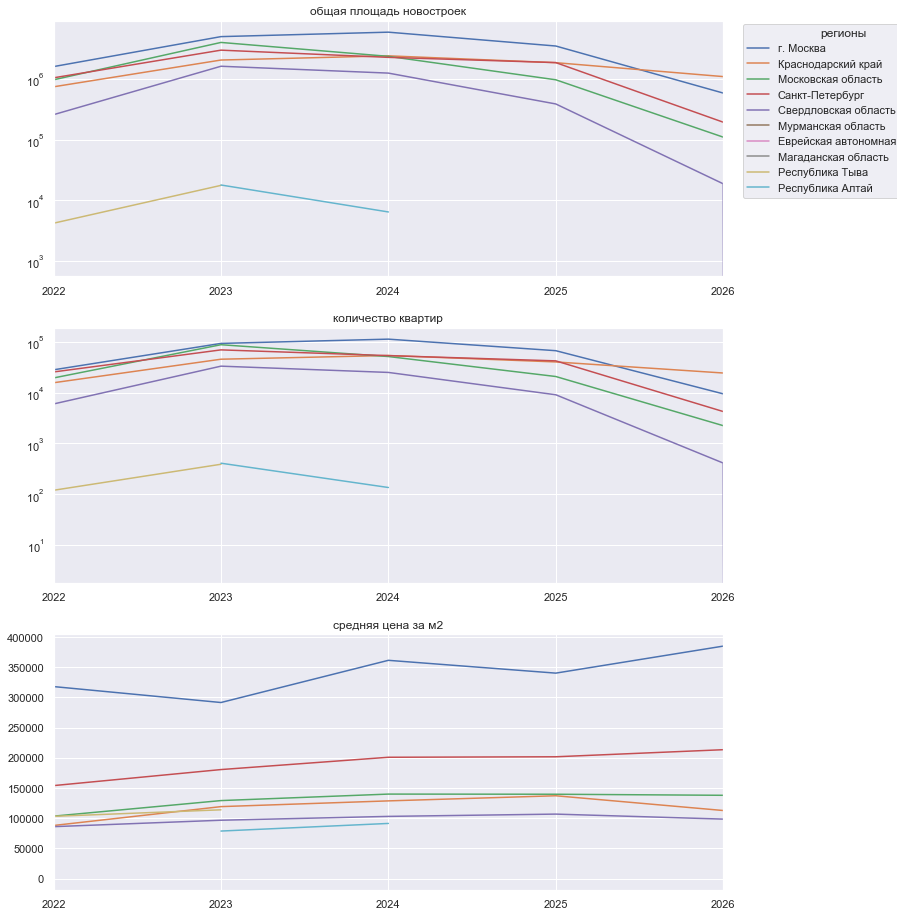

In [1954]:
#посмотрим на динамику объемов выводимого жилья

fig, axs = plt.subplots(nrows= 3 , ncols= 1 )
fig.set_size_inches(12,16)


for rg in v_rgns:
    axs[0].plot(df_Anlz1[df_Anlz1.region==rg]['Year'], df_Anlz1[df_Anlz1.region==rg]['objSquareLiving'])
    axs[1].plot(df_Anlz1[(df_Anlz1.region==rg)]['Year'], df_Anlz1[df_Anlz1.region==rg]['objFlatCnt'])
    axs[2].plot(df_Anlz1[(df_Anlz1.region==rg)]['Year'], df_Anlz1[df_Anlz1.region==rg]['objPriceAvg'])

fig.legend(title='регионы', labels=v_rgns.map(map_regions), bbox_to_anchor=(1.1, 0.78))

for i in range (0, 3):    
    axs[i].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    #возьмем данный за ближайшие 5 лет
    axs[i].set_xlim([2022, 2026])
    
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(1))

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].set_title('общая площадь новостроек')
axs[1].set_title('количество квартир')
axs[2].set_title('средняя цена за м2')

plt.show()

Выводы:
    - В наиболее активно строящихся регионах планы по застройке равномерные, без явных пиков или спадов в объемах выводимого жилья. Прослеживается уменьшение объемов к 2025-2026 году. Предположительно это объясняется тем, что - это довольно отдаленный срок, и планы на застройку еще не попали в базу.
    - В наименее активно строящихся регионах застройка происходит "штучно", четкие тенденции не прослеживаются 
    - Цены на жильё в Москве занчительно выше, чем в осталных регионах
    - Динамика цен в сторону роста

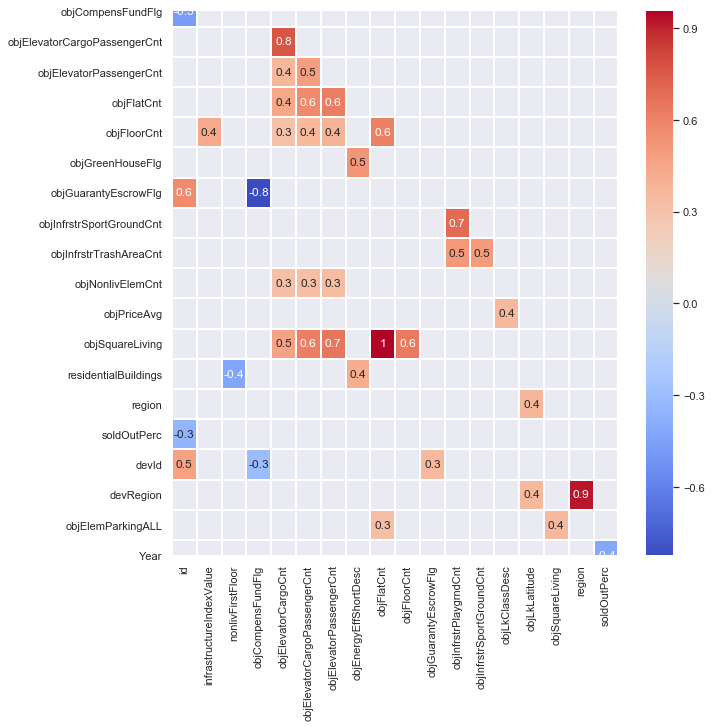

In [1955]:
#отрисуем, как коррелиируются между собой параметры объектов по всем имеющимся данным
df_Anlz2=df_Objects.corr()

    #уберем строки и столбцы, в которых данные слабо коррелируются
    # для этого убираем главную диагональ и все, что правее (данные в правой части дублируют данные в левой)
mask=np.ones_like(df_Anlz2).astype(int)
mask[np.triu_indices_from(mask)]=0
df_Anlz2 = df_Anlz2 * (mask)
    #отметаем все, что слабо коррелируется  (оставим коэфф корреляции больше 0,3)
df_Anlz2=df_Anlz2[(abs(df_Anlz2)>0.3)].dropna(axis = 0, thresh=1).dropna(axis = 1, thresh=1)

    #отрисуем тепловую карту
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(
    df_Anlz2,
    cmap= 'coolwarm',
    linewidths=1,
    annot = True,
        #mask=mask,
    fmt='.1g'
    )

Выводы:
- Количество общая плошадь жилых помещений в доме находятся в прямой пропорции
- большинство застройщиков строят в своем регионе
- Продажа через эскроу счета и гарантии от фондов находятся в сильной обратной зависимости.
- Прямые связи средней силы имеются между количеством лифтов и количеством (и площадью) жилых помещений. 
  Связь количества лифтов с этажностью здания тоже есть, но более слабая.
- Прямой связью связаны количество спортивных и игровых площадок
- Наблюдаестя положительная связь средней силы между энергоэффективностью дома и признаком "зеленый дом". 
  А вот явной связи между энергоэффективностью и географической широтой не выявлено. Хотя такая связь казалась бы логичной.
- есть зависимость стоимости от класса жилья, но она слабая. Вероятно, из-за разбросов в стоимости жилья по регионам, посмотрим этот момент на следующем графике

In [2047]:
current_palette = sns.color_palette(n_colors=len(map_LkClass))
current_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254)]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


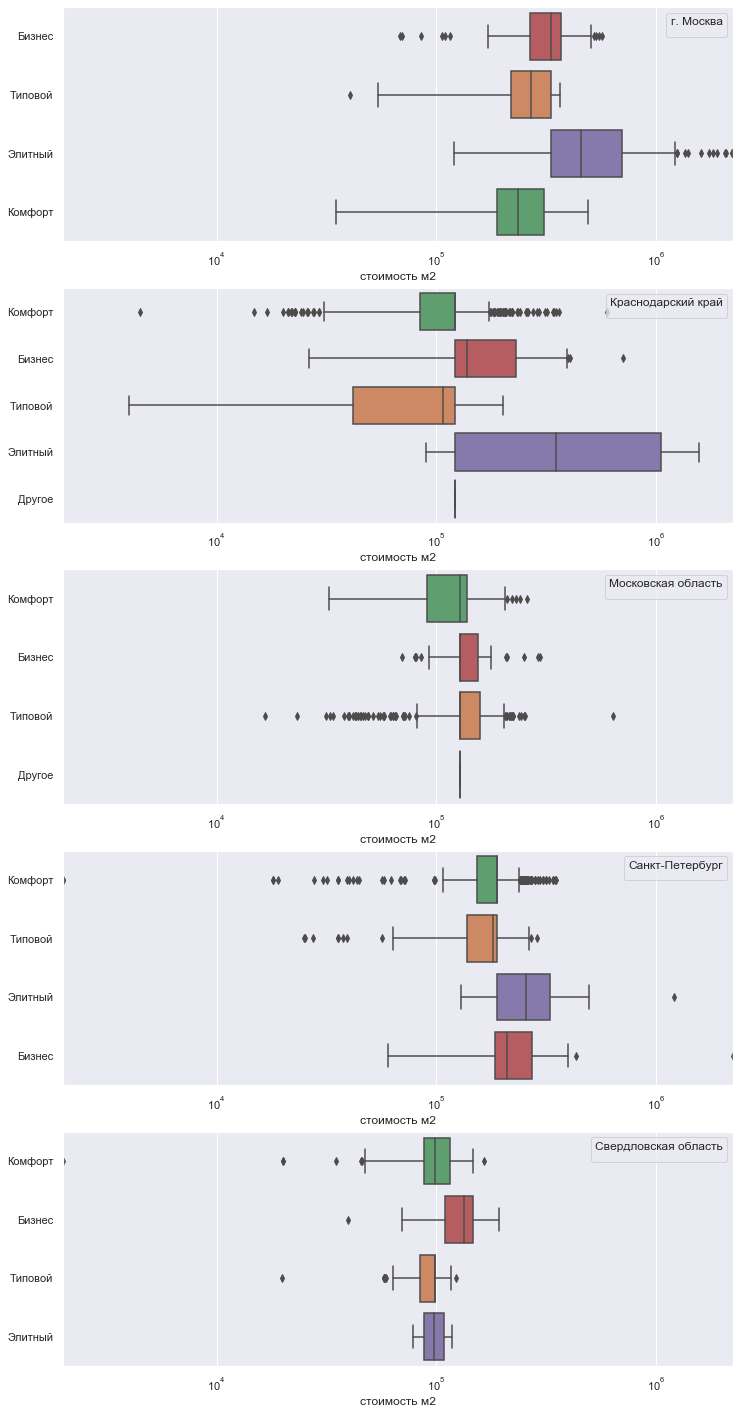

In [2048]:
#визуализируем разброс средней стоимости м2 в регионах с максимально активной застройкой

df_Anlz3=df_Objects[df_Objects.region.isin(v_rgns_max)][['objPriceAvg','region','objLkClassDesc']]

#df_Anlz3['region_nm']=df_Anlz3['region'].map(map_regions)
map_LkClass_reverse = dict(zip(map_LkClass.values(), map_LkClass.keys()))
df_Anlz3['objLkClassDesc']=df_Anlz3['objLkClassDesc'].map(map_LkClass_reverse)
v_xmin=df_Anlz3['objPriceAvg'].min()
v_xmax=df_Anlz3['objPriceAvg'].max()

v_palette=dict(zip(map_LkClass.keys(), sns.color_palette(n_colors=len(map_LkClass))))


fig, axs = plt.subplots(len(v_rgns_max), 1)
fig.set_size_inches(12,5*len(v_rgns_max))

for i, rgn in enumerate(v_rgns_max,  start=0):
    sns.boxplot(
        y='objLkClassDesc',
        x='objPriceAvg', 
        data=df_Anlz3[df_Anlz3.region==rgn],
        ax=axs[i] ,
        palette=v_palette
        )
    axs[i].legend(title=map_regions.get(rgn), loc='upper right')
    axs[i].set_xlabel('стоимость м2')
    axs[i].set_ylabel(None)
    axs[i].set_xlim([v_xmin, v_xmax])
    axs[i].set_xscale('symlog')

#bx.legend(title='класс недвижимости')
#sns.set_xlabel("регион", fontsize=14)
#bx.set_xlim([df_Anlz3['objPriceAvg'].min(), df_Anlz3['objPriceAvg'].max()])
#bx.set_xscale('symlog', linthreshy=1)
#sns.legend(bbox_to_anchor=(1.2, 0.78))


In [ ]:
Выводы:
    - Стоимось м2 жилья в целом в большей степени зависит от региона, чем от класса. 
    - Наибольший разброс по стоимости жилья наблюдается в Краснодарском крае, особенно в элитном классе.

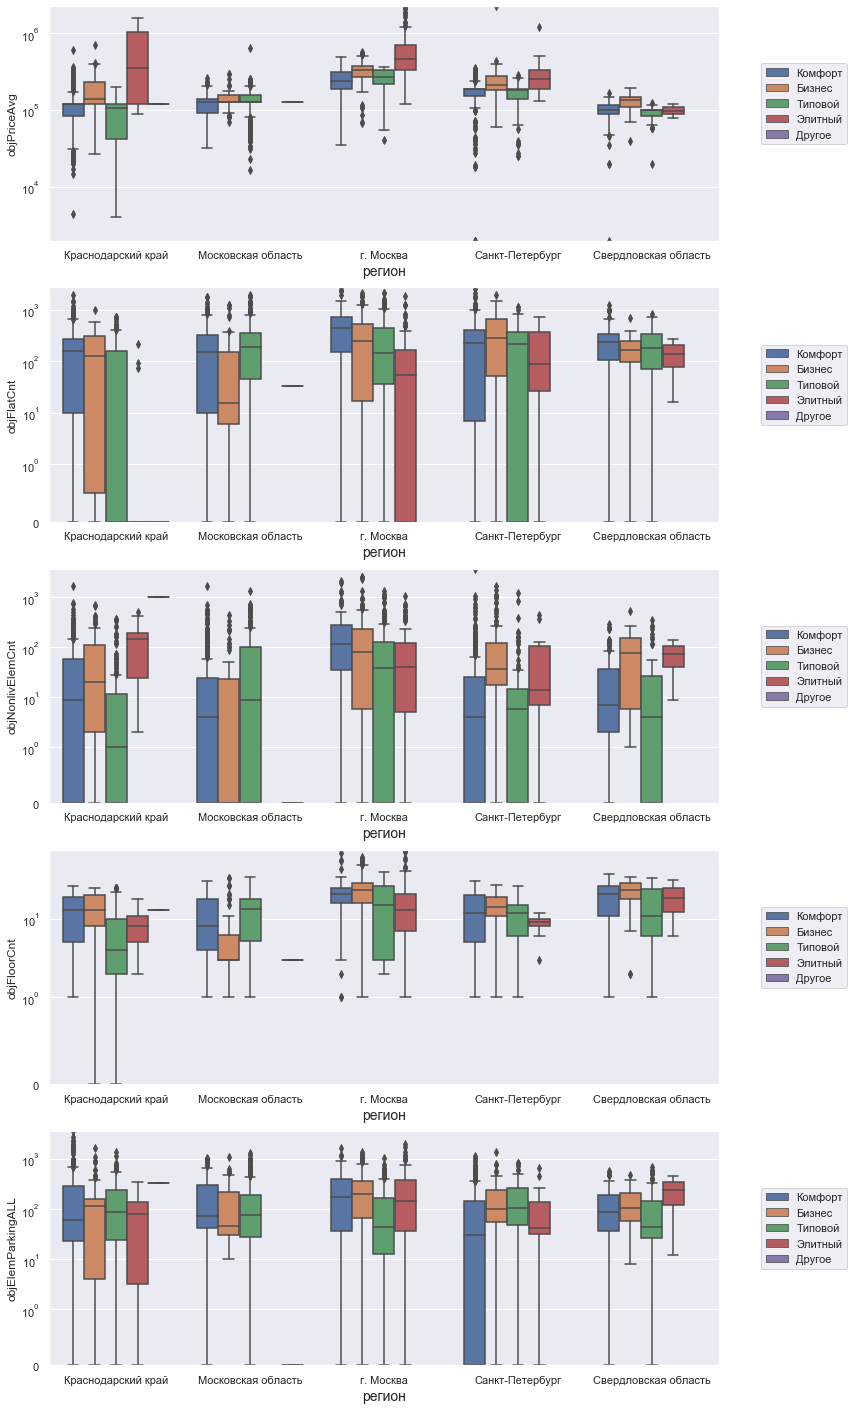

In [1981]:
#визуализируем разброс некоторых покахателей в регионах с максимально активной застройкой
#v_params=['objPriceAvg','objFlatCnt']
v_params=['objPriceAvg','objFlatCnt', 'objNonlivElemCnt', 'objFloorCnt', 'objElemParkingALL']

df_Anlz3=df_Objects[df_Objects.region.isin(v_rgns_max)][v_params+['region','objLkClassDesc']]
#df_Anlz3=df_Anlz3[df_Anlz3.objFlatCnt>0]

df_Anlz3['region']=df_Anlz3['region'].map(map_regions)
map_LkClass_reverse = dict(zip(map_LkClass.values(), map_LkClass.keys()))
df_Anlz3['objLkClassDesc']=df_Anlz3['objLkClassDesc'].map(map_LkClass_reverse)

fig, axs = plt.subplots(len(v_params), 1)
fig.set_size_inches(12,5*len(v_params))

for i in range(len(v_params)):
    sns.boxplot(
        x='region',
        y=v_params[i], 
        data=df_Anlz3,
        hue='objLkClassDesc',
        ax=axs[i]
        )
    axs[i].legend(title='класс недвижимости')
    axs[i].set_xlabel("регион", fontsize=14)
    axs[i].set_ylim([df_Anlz3[v_params[i]].min(), df_Anlz3[v_params[i]].max()])
    axs[i].set_yscale('symlog', linthreshy=1)
    axs[i].legend(bbox_to_anchor=(1.2, 0.78))


SyntaxError: invalid syntax (<ipython-input-1980-68d1b1a9e209>, line 1)

In [1959]:
df_Objects[(df_Objects.objFlatCnt==0)&(df_Objects.objNonlivElemCnt!=0)][['objFlatCnt','objNonlivElemCnt','objSquareLiving']]

,objFlatCnt,objNonlivElemCnt,objSquareLiving
10,0,684,0.0
37,0,627,0.0
39,0,516,0.0
58,0,4,0.0
62,0,172,0.0
...,...,...,...
10721,0,1,0.0
10729,0,396,0.0
10759,0,133,0.0
10763,0,271,0.0


In [ ]:
f

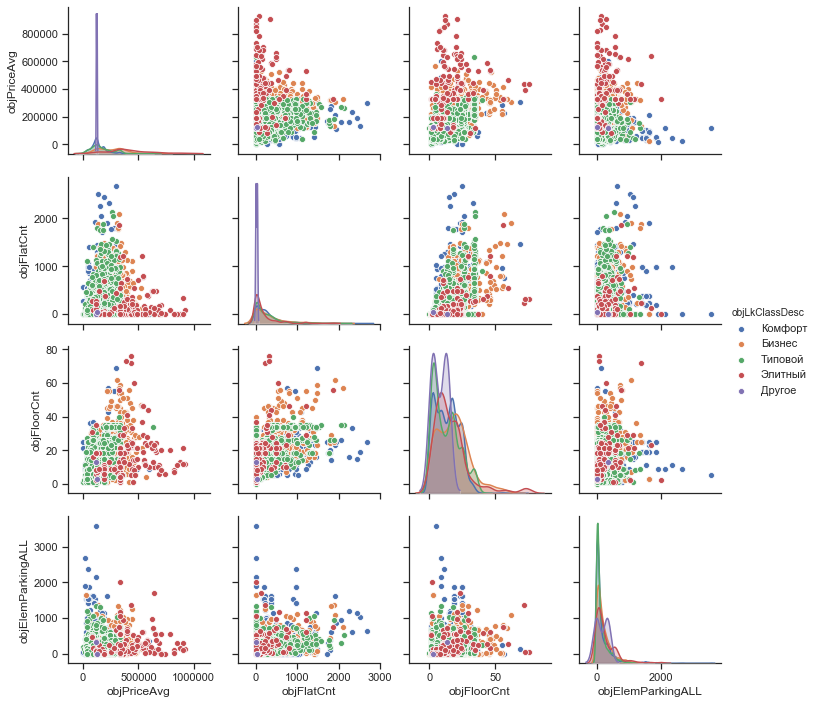

In [1363]:

sns.pairplot(df_Anlz2[df_Anlz2.objPriceAvg<1000000], hue='objLkClassDesc')


In [1361]:
    2) По средней полщади квартир в новостройках также в основном наблюдается стабильность,
    есть тенденции к росту средней плошади в Москве и Новосибирской области для объектов, заплпнированных к сдаче после 2025 года
    3) По средней этажности знаний в лидерах Москва и Свердловская область. За что Свердловской области моё личное фи (слишком плотно всё это многоэтажное добро строится, со всеми вытекающими)... 
    

SyntaxError: invalid syntax (<ipython-input-1361-1bf7c05a1aec>, line 1)